In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import seaborn as sns

---
# Load files and Functions

## Load files

In [146]:
#read bridges and info about LRP data
lrp=pd.read_csv('../data/raw/Roads_InfoAboutEachLRP.csv', low_memory=False)
df_bridges = pd.read_excel("../data/raw/BMMS_overview.xlsx")
road=pd.read_csv('../data/processed/_roads.tsv', sep='\t', low_memory=False) #take the already proceesd road data as input

In [147]:
# ---- Load wide file (like you already did) ----
road = road.copy()

# Make sure first column is named 'road'
road = road.rename(columns={road.columns[0]: "road"})

tidy_rows = []

for _, row in road.iterrows():
    road_name = row["road"]
    
    # Everything after first column are repeating triples
    values = row.iloc[1:].values
    
    # Loop through in steps of 3 (lrp, lat, lon)
    for i in range(0, len(values), 3):
        try:
            lrp = values[i]
            lat = values[i+1]
            lon = values[i+2]
        except IndexError:
            break  # incomplete triple at end
        
        # Skip completely empty triples
        if pd.isna(lrp) and pd.isna(lat) and pd.isna(lon):
            continue
        
        tidy_rows.append({
            "road": road_name,
            "lrp": lrp,
            "lat": pd.to_numeric(lat, errors="coerce"),
            "lon": pd.to_numeric(lon, errors="coerce")
        })

# Create tidy dataframe
tidy = pd.DataFrame(tidy_rows)

# Drop rows where everything is missing
tidy = tidy.dropna(subset=["lrp", "lat", "lon"], how="all")

# Reset index
tidy = tidy.reset_index(drop=True)

print("Tidy shape:", tidy.shape)

Tidy shape: (51861, 4)


## Fixing roads function

In [72]:
import re

_lrp_re = re.compile(r"^LRP(\d+)([A-Za-z]*)$")

def lrp_sort_key(lrp: str):
    """
    Returns a tuple used for sorting LRPs in chainage-like order:
    LRPS, LRPSa, LRPSb ... first
    then LRP001, LRP001a, LRP001b ...
    then ...
    LRPE last
    Unknown formats go to the end (but before LRPE).
    """
    if pd.isna(lrp):
        return (10**9, "zz")  # push NA to end
    
    s = str(lrp).strip()

    # Start markers
    if s == "LRPS":
        return (-1, "")
    if s.startswith("LRPS") and len(s) > 4:
        # LRPSa, LRPSb ...
        return (-1, s[4:])

    # End marker
    if s == "LRPE":
        return (10**12, "zzzz")

    # Standard LRP###suffix
    m = _lrp_re.match(s)
    if m:
        num = int(m.group(1))
        suf = m.group(2) or ""
        return (num, suf)

    # fallback for weird labels
    return (10**9, s)

def sort_road_by_lrp(df_points):
    df = df_points.copy()
    df["_k"] = df["lrp"].apply(lrp_sort_key)
    df = df.sort_values("_k").drop(columns="_k").reset_index(drop=True)
    return df


In [92]:
# ----------------------------
# Distance
# ----------------------------
def haversine(lat1, lon1, lat2, lon2):
    R = 6371.0
    lat1, lon1, lat2, lon2 = map(np.radians, [lat1, lon1, lat2, lon2])
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    a = np.sin(dlat/2)**2 + np.cos(lat1)*np.cos(lat2)*np.sin(dlon/2)**2
    c = 2 * np.arcsin(np.sqrt(a))
    return R * c

def compute_segments(df):
    """Adds next_lat/next_lon + seg distance. Expects ordered points."""
    out = df.copy()
    out["next_lat"] = out["lat"].shift(-1)
    out["next_lon"] = out["lon"].shift(-1)
    out["seg"] = haversine(out["lat"], out["lon"], out["next_lat"], out["next_lon"])
    return out

# ----------------------------
# Stage A: Block repair
# ----------------------------
def block_repair(df_points, K=15, min_run_len=2):
    """
    Detect consecutive jump segments and linearly interpolate across the block.
    df_points: columns ['lrp','lat','lon'] in correct order.
    Returns: fixed_df, actions(list)
    """
    df = compute_segments(df_points).reset_index(drop=True)
    median_seg = df["seg"].median()
    thr = K * median_seg

    df["is_jump_seg"] = df["seg"] > thr
    df["run_id"] = (df["is_jump_seg"] != df["is_jump_seg"].shift()).cumsum()

    jump_runs = df[df["is_jump_seg"]].groupby("run_id").indices
    fixed = df_points.copy().reset_index(drop=True)
    actions = []

    for run_id, idxs in jump_runs.items():
        idxs = list(idxs)
        if len(idxs) < min_run_len:
            continue

        # segments idxs[0]..idxs[-1] correspond to points [left_idx .. right_idx]
        left_idx = idxs[0]
        right_idx = idxs[-1] + 1

        # bounds + must have endpoints
        if left_idx <= 0 or right_idx >= len(fixed):
            continue
        if fixed.loc[left_idx, ["lat","lon"]].isna().any() or fixed.loc[right_idx, ["lat","lon"]].isna().any():
            continue

        L = right_idx - left_idx
        for k in range(1, L):
            new_lat = fixed.loc[left_idx, "lat"] + (fixed.loc[right_idx, "lat"] - fixed.loc[left_idx, "lat"]) * (k / L)
            new_lon = fixed.loc[left_idx, "lon"] + (fixed.loc[right_idx, "lon"] - fixed.loc[left_idx, "lon"]) * (k / L)

            old_lat, old_lon = fixed.loc[left_idx+k, "lat"], fixed.loc[left_idx+k, "lon"]
            fixed.loc[left_idx+k, "lat"] = new_lat
            fixed.loc[left_idx+k, "lon"] = new_lon

            actions.append({
                "idx": left_idx+k,
                "lrp": fixed.loc[left_idx+k, "lrp"],
                "action": "block_interp",
                "old_lat": old_lat, "old_lon": old_lon,
                "new_lat": new_lat, "new_lon": new_lon,
                "run_len": len(idxs),
                "thr_km": thr
            })

    return fixed, actions

# ----------------------------
# Stage B: Smart single-segment repair
# ----------------------------
def smart_single_seg_repair(df_points, K=15, max_iters=5):
    """
    Fix remaining isolated jump segments by deciding whether to adjust point i or i+1.
    df_points: columns ['lrp','lat','lon'] ordered.
    Returns: fixed_df, actions(list)
    """
    df = df_points.copy().reset_index(drop=True)
    actions = []

    for _ in range(max_iters):
        tmp = compute_segments(df)
        med = tmp["seg"].median()
        thr = K * med

        bad_idxs = tmp.index[tmp["seg"] > thr].tolist()
        if not bad_idxs:
            break

        for i in bad_idxs:
            # need neighborhood i-1, i, i+1, i+2
            if i <= 0 or i >= len(df)-2:
                continue

            p_im1 = (df.loc[i-1, "lat"], df.loc[i-1, "lon"])
            p_i   = (df.loc[i,   "lat"], df.loc[i,   "lon"])
            p_ip1 = (df.loc[i+1, "lat"], df.loc[i+1, "lon"])
            p_ip2 = (df.loc[i+2, "lat"], df.loc[i+2, "lon"])

            if any(pd.isna([*p_im1, *p_i, *p_ip1, *p_ip2])):
                continue

            cur = (
                haversine(p_im1[0], p_im1[1], p_i[0], p_i[1]) +
                haversine(p_i[0], p_i[1], p_ip1[0], p_ip1[1]) +
                haversine(p_ip1[0], p_ip1[1], p_ip2[0], p_ip2[1])
            )

            # Fix A: adjust point i
            fixA = ((p_im1[0] + p_ip1[0]) / 2, (p_im1[1] + p_ip1[1]) / 2)
            scoreA = (
                haversine(p_im1[0], p_im1[1], fixA[0], fixA[1]) +
                haversine(fixA[0], fixA[1], p_ip1[0], p_ip1[1]) +
                haversine(p_ip1[0], p_ip1[1], p_ip2[0], p_ip2[1])
            )

            # Fix B: adjust point i+1
            fixB = ((p_i[0] + p_ip2[0]) / 2, (p_i[1] + p_ip2[1]) / 2)
            scoreB = (
                haversine(p_im1[0], p_im1[1], p_i[0], p_i[1]) +
                haversine(p_i[0], p_i[1], fixB[0], fixB[1]) +
                haversine(fixB[0], fixB[1], p_ip2[0], p_ip2[1])
            )

            best = min(cur, scoreA, scoreB)
            if best >= cur:
                continue

            if best == scoreA:
                old_lat, old_lon = df.loc[i, "lat"], df.loc[i, "lon"]
                df.loc[i, "lat"], df.loc[i, "lon"] = fixA
                actions.append({
                    "idx": i,
                    "lrp": df.loc[i, "lrp"],
                    "action": "smart_fix_i_mid(im1,ip1)",
                    "old_lat": old_lat, "old_lon": old_lon,
                    "new_lat": fixA[0], "new_lon": fixA[1],
                    "thr_km": thr
                })
            else:
                old_lat, old_lon = df.loc[i+1, "lat"], df.loc[i+1, "lon"]
                df.loc[i+1, "lat"], df.loc[i+1, "lon"] = fixB
                actions.append({
                    "idx": i+1,
                    "lrp": df.loc[i+1, "lrp"],
                    "action": "smart_fix_i+1_mid(i,ip2)",
                    "old_lat": old_lat, "old_lon": old_lon,
                    "new_lat": fixB[0], "new_lon": fixB[1],
                    "thr_km": thr
                })

    return df, actions

# ----------------------------
# Full repair for one road
# ----------------------------
def repair_road_points(df_road_points, K=15, min_run_len=2):
    # ✅ NEW: sort by LRP before any distance work
    df_road_points = sort_road_by_lrp(df_road_points)

    before = compute_segments(df_road_points)
    before_med = before["seg"].median()
    before_thr = K * before_med
    before_jumps = int((before["seg"] > before_thr).sum())
    before_max = float(before["seg"].max())

    fixedA, actionsA = block_repair(df_road_points, K=K, min_run_len=min_run_len)
    fixedB, actionsB = smart_single_seg_repair(fixedA, K=K)

    after = compute_segments(fixedB)
    after_med = after["seg"].median()
    after_thr = K * after_med
    after_jumps = int((after["seg"] > after_thr).sum())
    after_max = float(after["seg"].max())

    metrics = {
        "median_seg_before": before_med,
        "thr_before": before_thr,
        "jumps_before": before_jumps,
        "max_seg_before": before_max,
        "median_seg_after": after_med,
        "thr_after": after_thr,
        "jumps_after": after_jumps,
        "max_seg_after": after_max,
        "actions_block": len(actionsA),
        "actions_smart": len(actionsB),
        "actions_total": len(actionsA) + len(actionsB),
    }

    actions = actionsA + actionsB
    return fixedB, actions, metrics


# ----------------------------
# Plot before/after for a road
# ----------------------------
def plot_road_before_after(tidy_df, road_name, fixed_df=None, K=15, title_suffix=""):
    """
    tidy_df: full tidy dataframe (road, lrp, lat, lon) in original order
    fixed_df: optional fixed points (lrp, lat, lon) for the road; if None we repair on the fly.
    """
    road_pts = tidy_df[tidy_df["road"] == road_name][["lrp","lat","lon"]].copy().reset_index(drop=True)

    if fixed_df is None:
        fixed_df, _, metrics = repair_road_points(road_pts, K=K)
    else:
        metrics = None

    # plot side-by-side
    fig, axes = plt.subplots(1, 2, figsize=(14, 6))

    axes[0].plot(road_pts["lon"], road_pts["lat"], marker="o", markersize=2, linewidth=1)
    axes[0].set_title(f"{road_name} BEFORE {title_suffix}")
    axes[0].set_xlabel("Longitude")
    axes[0].set_ylabel("Latitude")

    axes[1].plot(fixed_df["lon"], fixed_df["lat"], marker="o", markersize=2, linewidth=1)
    axes[1].set_title(f"{road_name} AFTER {title_suffix}")
    axes[1].set_xlabel("Longitude")
    axes[1].set_ylabel("Latitude")

    plt.tight_layout()
    plt.show()

    if metrics is not None:
        print(metrics)
    

# ----------------------------
# Repair ALL roads
# ----------------------------
def repair_all_roads(tidy_df, K=15, min_run_len=2, max_roads=None):
    """
    tidy_df: columns ['road','lrp','lat','lon'] in original order
    Returns: cleaned_tidy_df, actions_df, metrics_df
    """
    cleaned_parts = []
    all_actions = []
    all_metrics = []

    roads = tidy_df["road"].dropna().unique().tolist()
    if max_roads is not None:
        roads = roads[:max_roads]

    for r in roads:
        road_pts = tidy_df[tidy_df["road"] == r].copy().reset_index(drop=True)
        fixed_pts, actions, metrics = repair_road_points(road_pts, K=K, min_run_len=min_run_len)

        fixed_out = fixed_pts.copy()
        #fixed_out.insert(0, "road", r)
        cleaned_parts.append(fixed_out)

        for a in actions:
            a["road"] = r
        all_actions.extend(actions)

        metrics["road"] = r
        all_metrics.append(metrics)

    cleaned = pd.concat(cleaned_parts, ignore_index=True)
    actions_df = pd.DataFrame(all_actions)
    metrics_df = pd.DataFrame(all_metrics)

    return cleaned, actions_df, metrics_df


In [90]:
def plot_road_before_after_2(tidy_df, road_name, fixed_df=None, K=15, title_suffix=""):
    """
    tidy_df: full tidy dataframe (road, lrp, lat, lon) in original order
    fixed_df: optional fixed points (lrp, lat, lon) for the road; if None we repair on the fly.
    """
    road_pts = tidy_df[tidy_df["road"] == road_name].copy().reset_index(drop=True)

    if fixed_df is None:
        fixed_df, _, metrics = repair_road_points(road_pts, K=K)
    else:
        metrics = None

    fixed_df2, _, metrics = repair_road_points(fixed_df, K=K)
    
    # plot side-by-side
    fig, axes = plt.subplots(1, 2, figsize=(14, 6))

    axes[0].plot(road_pts["lon"], road_pts["lat"], marker="o", markersize=2, linewidth=1)
    axes[0].set_title(f"{road_name} BEFORE {title_suffix}")
    axes[0].set_xlabel("Longitude")
    axes[0].set_ylabel("Latitude")

    axes[1].plot(fixed_df2["lon"], fixed_df2["lat"], marker="o", markersize=2, linewidth=1)
    axes[1].set_title(f"{road_name} AFTER {title_suffix}")
    axes[1].set_xlabel("Longitude")
    axes[1].set_ylabel("Latitude")

    plt.tight_layout()
    plt.show()

    if metrics is not None:
        print(metrics)
    


In [75]:
def plot_all_roads_before_after(tidy_df, cleaned_df):
    fig, axes = plt.subplots(1, 2, figsize=(16, 7))

    # BEFORE
    axes[0].scatter(
        tidy_df["lon"], tidy_df["lat"],
        s=1, alpha=0.5
    )
    axes[0].set_title("All Roads BEFORE Repair")
    axes[0].set_xlabel("Longitude")
    axes[0].set_ylabel("Latitude")

    # AFTER
    axes[1].scatter(
        cleaned_df["lon"], cleaned_df["lat"],
        s=1, alpha=0.5
    )
    axes[1].set_title("All Roads AFTER Repair")
    axes[1].set_xlabel("Longitude")
    axes[1].set_ylabel("Latitude")

    plt.tight_layout()
    plt.show()


## Chainage monotony function

In [3]:
#Function to check monotony in datasets

def check_chainage_monotony(df):
    # convert the chainage column to numeric values, if value cannot be converted it becomes NaN
    df["chainage"] = pd.to_numeric(df["chainage"], errors="coerce")
    # create empty list to store True or False values indicating whether there's monotony within each road group
    report = []
    # loop through each group of rows grouped by "road"
    for road, group in df.groupby("road"):
        # reset index inside each group so iteration start from 0 (and drop old index column)
        group = group.reset_index(drop=True)
        # variable to keep track of previous chainage value
        prev_chainage = None
        # iterate through each row in the grouped DataFrame
        for i, row in group.iterrows():
            current_chainage = row["chainage"]

            # it it's the first row in the group, it will automatically be marked as monotone (True)
            if prev_chainage is None:
                report.append(True)
            else:
                # Check if current chainage is greater than or equal to the previous one
                report.append(current_chainage >= prev_chainage)
            # update chainage for next iteration
            prev_chainage = current_chainage

    # add the report as new column to original dataframe
    df["monotone"] = report

    not_monotone = df.groupby("road")["monotone"].all().eq(False).sum()
    # print results
    if not_monotone == 0:
        print("All roads in the dataset have chainage monotony")
    else:
        print(not_monotone, "roads break chainage monotony")
        road_monotone = df.groupby("road")["monotone"].all()
        broken_roads = road_monotone[road_monotone ==False].index
        print("Roads that break monotony:", broken_roads)

In [27]:
# Observing the dataset, the roads seem to be all over the place
# N1 in initial rows but also afterwards
# Here's a function to group and sort them in order

def fix_chainage_monotony(df): 
    df = df.copy()
    # group frist by road and sort each road by chainage
    df_sorted = df.sort_values(by=["road", "chainage"]).reset_index(drop=True)
    return df_sorted

## Inverted lon lat function

In [166]:
min_lat, max_lat = 20.86382, 26.33338
min_lon, max_lon = 88.15638, 92.30153

def detect_bridges_inverted_coordinates(df1, lat_col='lat', lon_col='lon', road_col='road', lrp_col='LRPName'):
    df=df1.copy()
    # Create flags for inverted coordinates and far-out coordinates
    df['inverted_coords'] = (
        (df[lat_col] >= min_lon) & (df[lat_col] <= max_lon) &  # Latitude in longitude range
        (df[lon_col] >= min_lat) & (df[lon_col] <= max_lat)    # Longitude in latitude range
    )
    
    return df

In [169]:
def swap_lat_lon(df1):
    """
    Swap lat/lon only where inverted_coords == True
    and set the flag to False after correction

    Returns:
        corrected dataframe
        log dataframe
    """

    df = df1.copy()

    mask = df["inverted_coords"] == True

    # ---- CREATE LOG BEFORE CHANGING ----
    log_df = pd.DataFrame({
        "road": df.loc[mask, "road"],
        "LRPName": df.loc[mask, "LRPName"],
        "old_lat": df.loc[mask, "lat"],
        "old_lon": df.loc[mask, "lon"],
        "new_lat": df.loc[mask, "lon"],
        "new_lon": df.loc[mask, "lat"],
    }).reset_index(drop=True)

    # ---- SWAP COORDINATES ----
    df.loc[mask, ["lat", "lon"]] = df.loc[mask, ["lon", "lat"]].values

    # ---- TURN OFF FLAG ----
    df.loc[mask, "inverted_coords"] = False

    return df, log_df

## Out of boundary box function

In [167]:
def detect_bridges_out_coordinates(df1, lat_col='lat', lon_col='lon', road_col='road', lrp_col='LRPName'):
    df=df1.copy()
        
    df['far_out_coords'] = ( 
        ((df[lat_col] < min_lat) | (df[lat_col] > max_lat)) &  # Latitude outside range
        ((df[lon_col] < min_lon) | (df[lon_col] > max_lon))    # Longitude outside range
    )
    
    return df

In [151]:
def fix_far_out_coords(b, lrp):
    """
    Correct coordinates in dataframe b using reference dataframe lrp.
    Only rows with far_out_coords == True are processed.

    Returns:
        corrected dataframe
        log dataframe of applied changes
    """

    b = b.copy()

    # rows to process
    mask = b["far_out_coords"] == True
    b_sub = b.loc[mask]

    # merge subset with reference
    merged = b_sub.merge(
        lrp[["road", "lrp", "lat", "lon"]],
        left_on=["road", "LRPName"],
        right_on=["road", "lrp"],
        how="left",
        suffixes=("", "_ref")
    )

    # rows where match exists
    matched = merged["lat_ref"].notna()

    # --- CREATE LOG ---
    log_df = pd.DataFrame({
        "road": merged.loc[matched, "road"],
        "LRPName": merged.loc[matched, "LRPName"],
        "old_lat": merged.loc[matched, "lat"],
        "old_lon": merged.loc[matched, "lon"],
        "new_lat": merged.loc[matched, "lat_ref"],
        "new_lon": merged.loc[matched, "lon_ref"],
    }).reset_index(drop=True)

    # --- UPDATE ORIGINAL DATAFRAME ---
    idx_to_update = b_sub.index[matched]

    b.loc[idx_to_update, "lat"] = merged.loc[matched, "lat_ref"].values
    b.loc[idx_to_update, "lon"] = merged.loc[matched, "lon_ref"].values
    b.loc[idx_to_update, "far_out_coords"] = False

    return b, log_df

## NaN Values lookup function

In [152]:
def fill_nan_coords(df, lrp):
    """
    Fill missing lat/lon in df using reference dataframe lrp.

    Conditions:
    - Only rows where lat OR lon is NaN are processed
    - Match on df.road == lrp.road AND df.LRPName == lrp.lrp
    - Only update when match exists
    - Returns corrected dataframe and log dataframe
    """

    df = df.copy()

    # rows needing coordinates
    mask = df["lat"].isna() | df["lon"].isna()
    df_sub = df.loc[mask]

    # merge with reference
    merged = df_sub.merge(
        lrp[["road", "lrp", "lat", "lon"]],
        left_on=["road", "LRPName"],
        right_on=["road", "lrp"],
        how="left",
        suffixes=("", "_ref")
    )

    # matched rows (have reference coordinates)
    matched = merged["lat_ref"].notna() & merged["lon_ref"].notna()

    # ---- LOG ----
    log_df = pd.DataFrame({
        "road": merged.loc[matched, "road"],
        "LRPName": merged.loc[matched, "LRPName"],
        "new_lat": merged.loc[matched, "lat_ref"],
        "new_lon": merged.loc[matched, "lon_ref"],
    }).reset_index(drop=True)

    # ---- UPDATE ORIGINAL DF ----
    idx_to_update = df_sub.index[matched]

    df.loc[idx_to_update, "lat"] = merged.loc[matched, "lat_ref"].values
    df.loc[idx_to_update, "lon"] = merged.loc[matched, "lon_ref"].values

    return df, log_df

---
# Chainage Monotony

In [131]:
check_chainage_monotony(df_bridges)

# the output is only one road with broken montony R750, 
# but seems this doesn't have coordinates nor much data, likely to be road
# in conclusion, both datasets 

507 roads break chainage monotony
Roads that break monotony: Index(['N1', 'N102', 'N104', 'N105', 'N106', 'N107', 'N108', 'N110', 'N2',
       'N204',
       ...
       'Z8716', 'Z8717', 'Z8803', 'Z8804', 'Z8806', 'Z8810', 'Z8814', 'Z8910',
       'Z8913', 'Z8915'],
      dtype='object', name='road', length=507)


In [132]:
df_sorted_bridges = fix_chainage_monotony(df_bridges)
check_chainage_monotony(df_sorted_bridges)

1 roads break chainage monotony
Roads that break monotony: Index(['R750'], dtype='object', name='road')


In [133]:
df_sorted_bridges.head(2)

,road,km,type,LRPName,name,length,condition,structureNr,roadName,chainage,...,constructionYear,spans,zone,circle,division,sub-division,lat,lon,EstimatedLoc,monotone
0,N1,1.800,Box Culvert,LRP001a,.,11.3,A,117861,Dhaka (Jatrabari)-Comilla (Mainamati)-Chittago...,1.800,...,2005.0,2.0,Dhaka,Dhaka,Narayanganj,Narayanganj-1,23.702889,90.450389,bcs1,True
1,N1,4.925,Box Culvert,LRP004b,.,6.6,A,117862,Dhaka (Jatrabari)-Comilla (Mainamati)-Chittago...,4.925,...,2006.0,1.0,Dhaka,Dhaka,Narayanganj,Narayanganj-1,23.693611,90.478833,bcs1,True


---
# Lattitude and Longitude Issues

In [134]:
# Call the function to see the swapped bridges in data
a = detect_bridges_wrong_coordinates(df_sorted_bridges)
#a[(a['inverted_coords']==True)]

In [170]:
df_brigdes_2,log_swap=swap_lat_lon(a)

In [171]:
log_swap

,road,LRPName,old_lat,old_lon,new_lat,new_lon
0,R241,LRP026a,91.544194,24.773694,24.773694,91.544194
1,R241,LRP027a,91.542389,24.786833,24.786833,91.542389
2,R241,LRP028a,91.541778,24.790944,24.790944,91.541778
3,R241,LRP028c,91.542083,24.796694,24.796694,91.542083
4,R241,LRP029a,91.543889,24.805111,24.805111,91.543889
5,R241,LRP031a,91.538722,24.816556,24.816556,91.538722
6,R241,LRP032a,91.534361,24.823833,24.823833,91.534361
7,R241,LRP032b,91.530556,24.828056,24.828056,91.530556
8,R241,LRP033a,91.527917,24.830944,24.830944,91.527917
9,R241,LRP033b,91.524083,24.835222,24.835222,91.524083


15 lrps swapped

---
# Out of boundary issues

In [175]:
b=detect_bridges_out_coordinates(df_brigdes_2)

In [176]:
b[(b['far_out_coords']==True)].shape[0] #number of out of bound LRPs

33

In [177]:
df_brigdes_3,log_outofbound=fix_far_out_coords(b, tidy) #try to get the far out from the already corrected road dataframe
log_outofbound

,road,LRPName,old_lat,old_lon,new_lat,new_lon
0,Z1099,LRP005a,20.670667,92.305528,20.820638,92.305500
1,Z1099,LRP005b,20.815917,92.307917,20.816000,92.307917
2,Z1099,LRP006a,20.814500,92.308667,20.812556,92.309917
3,Z1099,LRP006b,20.812556,92.309917,20.809917,92.311361
4,Z1099,LRP007a,20.803944,92.313611,20.803833,92.313861
5,Z1099,LRP007c,20.801972,92.314583,20.798333,92.315806
6,Z1099,LRP008a,20.798306,92.315611,20.796055,92.316749
7,Z1099,LRP008b,20.795639,92.316972,20.790805,92.318110


8 out of bound values patched

In [181]:
df_brigdes_3[(df_brigdes_3["far_out_coords"]==True)].shape[0] #number of uncorrected data (including lat lon 0.0)

25

---
# NaN Values issue

In [143]:
df_brigdes_3.columns

Index(['road', 'km', 'type', 'LRPName', 'name', 'length', 'condition',
       'structureNr', 'roadName', 'chainage', 'width', 'constructionYear',
       'spans', 'zone', 'circle', 'division', 'sub-division', 'lat', 'lon',
       'EstimatedLoc', 'monotone', 'inverted_coords', 'far_out_coords'],
      dtype='object')

In [179]:
df_brigdes_4,log_NaN=fill_nan_coords(df_brigdes_3, tidy) #try to get the nant from the already corrected road dataframe
log_NaN

,road,LRPName,new_lat,new_lon


no NaN found in the dataset, subject to remove

---
# Bridge Placement Adjustment

In [145]:
df_bridges_4=df_brigdes_4.rename(columns={'LRPName': 'lrp'})
df_bridges_4.head()

,road,km,type,lrp,name,length,condition,structureNr,roadName,chainage,...,zone,circle,division,sub-division,lat,lon,EstimatedLoc,monotone,inverted_coords,far_out_coords
0,N1,1.800,Box Culvert,LRP001a,.,11.30,A,117861,Dhaka (Jatrabari)-Comilla (Mainamati)-Chittago...,1.800,...,Dhaka,Dhaka,Narayanganj,Narayanganj-1,23.702889,90.450389,bcs1,True,False,False
1,N1,4.925,Box Culvert,LRP004b,.,6.60,A,117862,Dhaka (Jatrabari)-Comilla (Mainamati)-Chittago...,4.925,...,Dhaka,Dhaka,Narayanganj,Narayanganj-1,23.693611,90.478833,bcs1,True,False,False
2,N1,8.976,PC Girder Bridge,LRP008b,Kanch pur Bridge.,394.23,A,119889,Dhaka (Jatrabari)-Comilla (Mainamati)-Chittago...,8.976,...,Dhaka,Dhaka,Narayanganj,Narayanganj-1,23.704583,90.518833,road_precise,True,False,False
3,N1,8.976,PC Girder Bridge,LRP008b,KANCHPUR PC GIRDER BRIDGE,397.00,C,101102,Dhaka (Jatrabari)-Comilla (Mainamati)-Chittago...,8.976,...,Dhaka,Dhaka,Narayanganj,Narayanganj-1,23.702083,90.515917,bcs1,True,False,False
4,N1,10.543,Box Culvert,LRP010a,KATCHPUR BOX CULVERT,8.00,B,101106,Dhaka (Jatrabari)-Comilla (Mainamati)-Chittago...,10.543,...,Dhaka,Dhaka,Narayanganj,Vitikandi,23.702056,90.528194,bcs1,True,False,False


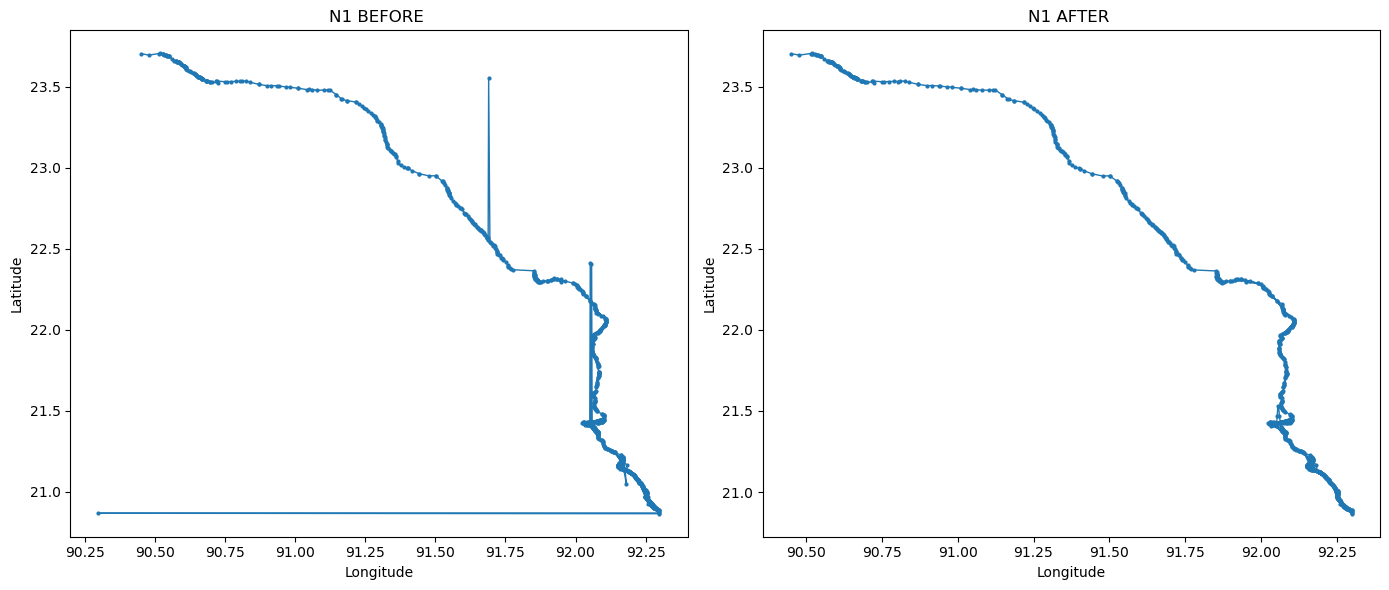

{'median_seg_before': 0.6585636184880912, 'thr_before': 9.878454277321367, 'jumps_before': 12, 'max_seg_before': 207.80079611309426, 'median_seg_after': 0.6457569364309788, 'thr_after': 9.68635404646468, 'jumps_after': 0, 'max_seg_after': 9.585754222687266, 'actions_block': 4, 'actions_smart': 18, 'actions_total': 22}


In [117]:
plot_road_before_after(df_bridges_4, "N1", K=15)

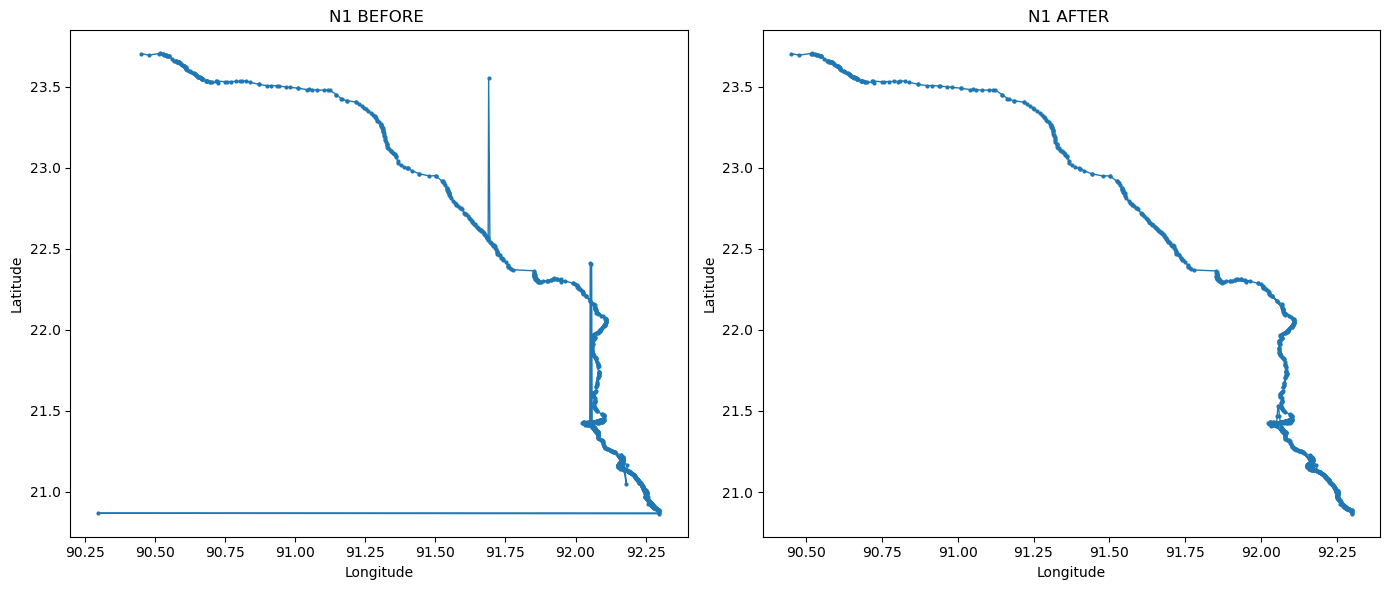

{'median_seg_before': 0.6444777532245357, 'thr_before': 9.667166298368036, 'jumps_before': 0, 'max_seg_before': 9.585754222687266, 'median_seg_after': 0.6444777532245357, 'thr_after': 9.667166298368036, 'jumps_after': 0, 'max_seg_after': 9.585754222687266, 'actions_block': 0, 'actions_smart': 0, 'actions_total': 0}


In [118]:
plot_road_before_after_2(df_bridges_4, "N1", K=15) #twice iteration of interpolation

In [93]:
cleaned_tidy, actions_df, metrics_df = repair_all_roads(df_bridges_4, K=15, min_run_len=2, max_roads=None)
print("Cleaned tidy shape:", cleaned_tidy.shape)
#plot_all_roads_before_after(df_bridges_4, cleaned_tidy)

Cleaned tidy shape: (21407, 23)


In [97]:
cleaned_tidy.columns

Index(['road', 'km', 'type', 'lrp', 'name', 'length', 'condition',
       'structureNr', 'roadName', 'chainage', 'width', 'constructionYear',
       'spans', 'zone', 'circle', 'division', 'sub-division', 'lat', 'lon',
       'EstimatedLoc', 'monotone', 'inverted_coords', 'far_out_coords'],
      dtype='object')

---
# Currently unable to fix bridge data

In [153]:
d=detect_bridges_out_coordinates(cleaned_tidy) #recheck out of boundary

In [164]:
d[(d['far_out_coords']==True)].shape[0] #number of still out of coordinate datas after lookup and interpolation

27

In [163]:
d[(d[["lat", "lon"]].isna().any(axis=1)==True)].shape[0] #number of NaN values in dataframe

94

In [165]:
problem_rows = d[
    d[["lat", "lon"]].isna().any(axis=1) |
    d["far_out_coords"]
]
problem_rows.shape[0] #rows where data is NaN or still out of bounds after look up and interpolation

121

---
# Comparison current tidy data to tidy data with problem rows removed in plot

In [182]:
valid_df = cleaned_tidy.drop(index=problem_rows.index)

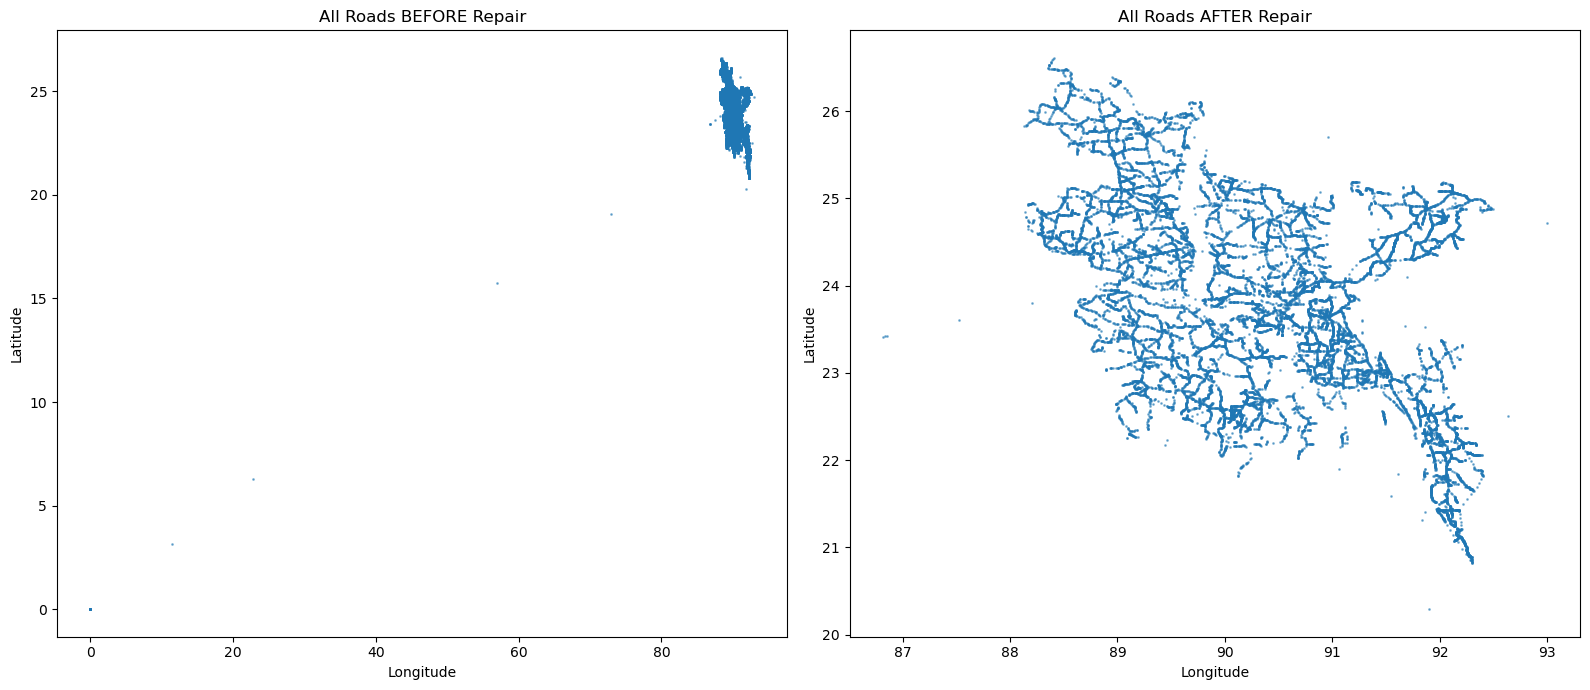

In [183]:
plot_all_roads_before_after(cleaned_tidy,valid_df)

---
# Write output to excel

In [126]:
cleaned_tidy.columns

Index(['road', 'km', 'type', 'lrp', 'name', 'length', 'condition',
       'structureNr', 'roadName', 'chainage', 'width', 'constructionYear',
       'spans', 'zone', 'circle', 'division', 'sub-division', 'lat', 'lon',
       'EstimatedLoc', 'monotone', 'inverted_coords', 'far_out_coords'],
      dtype='object')

In [127]:
#drop unused column and rename previously changed column
output_df = (
    cleaned_tidy
    .drop(columns=["monotone", "inverted_coords", "far_out_coords"])
    .rename(columns={"lrp": "LRPName"})
)

In [129]:
#write to excel file
output_df.to_excel("../data/processed/BMMS_overview.xlsx", index=False)